# Analyzing A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Datasets](#data)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [Source Index](#source)


<a id='intro'></a>
## Introduction
This project focuses on understanding the results of an A/B test run by an e-commerce website. The company developed a new page to increase conversion rates. The goal of this analysis is to explore and reveal insights to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision. 

<a id='data'></a>
## Datasets
This project consists of two datasets, one includes a/b testing information such as user_id, timestamp, group (control, treatment), landing page version, and converstion rates. The second dataset includes the same information by country. Both datasets were provided by Udacity. Similar datasets can be found online like [Kaggle's A/B Test Results an e-commerce website](https://www.kaggle.com/brittoh/a-b-test-results-an-e-commerce-website/notebook#A/B-Test-Results-an-e-commerce-website).

<a id='probability'></a>
## Part I - Probability

In [2]:
# Getting started by importing libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [43]:
# Reading ab_data.csv, storing it in df
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [44]:
# Looking at number of rows
df.shape[0]

294478

In [45]:
# Looking at number of unique users in the dataset
df['user_id'].nunique()

290584

In [46]:
# Looking at the proportion of users converted
df['converted'].mean()

0.11965919355605512

In [47]:
# Looking at number of times the 'new_page' and treatment don't match
df2 = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')")
df2.shape[0]

3893

In [48]:
# Checking to see if there are any missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**None of the rows have missing values.**

For the rows where 'treatment' does not match with 'new_page' or 'control' does not match with 'old_page', we can't assume this row truly received the new or old page. Moving on to address this discrepancy. 

In [49]:
# grouping 'control', 'treatment', and landing pages into df2
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [50]:
# Double checking all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [51]:
# Looking at the number of unique 'user_id's in df2
df2['user_id'].nunique()

290584

In [52]:
# There's one user_id repeated in df2, looking to see which id this is
df2[df2.duplicated(['user_id'])]['user_id'].unique()

array([773192])

In [53]:
# Looking at the row of the repeat 'user_id'
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [54]:
# Removing one of the rows with a duplicate user_id, keeping in df2
df2 = df2.drop_duplicates(['user_id'], keep='first')

In [55]:
# Looking at the probability of individual conversion rates (disregarding landing page versions)
df2['converted'].mean()

0.11959708724499628

In [56]:
# What would be the probability of an individual in the 'control' group converting?
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

The probability of an individual in the 'control' group converting (regardless of page type) is 0.120386

In [57]:
# What would be the probability of an individual in the 'treatment' group converting?
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

The probability of an individual in the 'treatment' group converting is 0.118808

In [58]:
# Looking at the probability that an individual received the new page
df2.query("landing_page == 'new_page'").shape[0] / df2.landing_page.shape[0]

0.5000619442226688

The probability that an individual received the new page is 0.500062

**The above analysis shows a nearly identical conversion rate of 12% for the control and treatment groups. There is not sufficient evidence suggesting that either page layout leads to more conversions.**

<a id='ab_test'></a>
## Part II - A/B Test

Based on the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed. However, the hard question is would I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long would I run to render a decision that neither page is better than another? These are some general A/B test questions that are difficult to answer based on my current knowledge. 

For now, I'm going to consider the scenario where a decision to made based on all the data provided. If I were to assume the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% my null and alternative hypotheses would be: 


**$$H_0: p_{old} - p_{new} \ge 0$$$$H_1: p_{old} - p_{new} < 0$$**

With $p_{old}$ and $p_{new}$ being the converted rates for the old and new pages.

For the analysis in this section, I'm going to assume the null hypothesis, $p_{new}$ and $p_{old}$, have "true" success rates equal to the 'converted' success rate regardles of page. In other words, $p_{new}$ and $p_{old}$ are equal. I'm also going to assume they're equal to the 'converted' rate in the ab_data.csv regardless of page.

A sampling distribution will be performed for the difference in 'converted' between the two pages over 10,000 interations of calculating and estimate from the null. I will use a sample size for each page equal to the ones in 'ab_data.csv.' The cells below provide the necessary parts of this simulation.

In [59]:
# Looking at the conversion rate for 'p_new' under the null
p_new = df2['converted'].mean()
p_new

0.11959708724499628

The conversion rate for $p_{new}$ under the null is 0.11951

In [60]:
# Looking at the conversion rate for 'p_old' under the null
p_old = df2['converted'].mean()
p_old

0.11959708724499628

The conversion rate for $p_{old}$ under the null is 0.11951

In [61]:
# Looking at the number of indivudals in the treatment 'n_new'
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

The number of individuals in the treatment group, $n_{new}$ is 145310.

In [62]:
# Looking at number of individuals in 'n_old' control group
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

The number of individuals in the control group, $n_{old}$, is 145274.

In [63]:
# Simulating 'n_new' transactions with a conversion rate of 'p_new' under the null
# Storing these 'n_new' 1's and 0's in 'new_page_converted'
new_page_converted = np.random.binomial(n_new,p_new)

In [64]:
# Simulating 'n_old' transactions with a conversion rate of 'p_old' under the null
# Storing 'n_old' 1's and 0's in 'old_page_converted'
old_page_converted = np.random.binomial(n_old,p_old)

In [65]:
# Finding 'p_new' - 'p_old' ( the difference) for simulated values from previous two cells
new_page_converted/n_new - old_page_converted/n_old

-0.000986116049097041

In [66]:
# Creating 10,000 p_new - p_old values using the same simulation process used in previous 7 cells above
# Storing all 10,000 values in a NumPy array 'p_diffs'
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old,p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

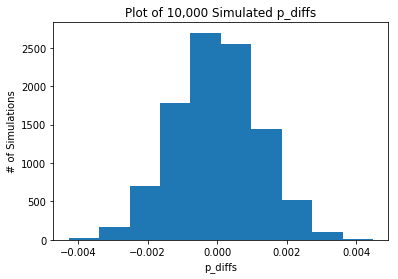

In [67]:
# Plotting a histogram of the p_diffs 
plt.hist(p_diffs);
plt.ylabel('# of Simulations')
plt.xlabel('p_diffs')
plt.title('Plot of 10,000 Simulated p_diffs');

Now I want to see what proportion of the 'p_diffs' are greater than the actual difference observed in the 'ab_data.csv.'

In [68]:
# Computing difference observed in csv dataset
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
print(act_diff) 
# Converting p_diffs into numpy array
p_diffs = np.array(p_diffs) 
# Computing the proportion of p_diffs greater than act_diff
(act_diff < p_diffs).mean()

-0.00157823898536


0.90200000000000002

**The calculated p-value gives insights into the probability of obtaining the same results assuming the null hypothesis is true. In this case, the large p-value of 0.90200 indicates weak evidence against the null hypothesis. Thus, we fail to reject the null hypothesis which suggests the new page conversion rate is higher than the old rate.**

Moving on to calculating the number of conversions for each page and the number of individuals who recieved each page. The lables 'n_old' and 'n_new' will be used to refer to the number of rows associated with the old page and new pages, respectively.

In [69]:
# Looking at number of conversions for each page and number of individuals who recieved each page
import statsmodels.api as sm
from pandas.core import datetools # pandas.core.datetools module removed in future versions

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]
convert_old

17489

In [70]:
# Using stats.proportions_ztest to compute my statistic and p-value
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [71]:
# Importing the norm function to compute the significance of z_score
from scipy.stats import norm
norm.cdf(z_score)

0.90505831275902449

In [72]:
# A 95% confidence interval was assumed for the single sides test, thus checking critical value at 95% confidence interval
norm.ppf(1-(0.05/2))

1.959963984540054

**The computed z-score of 1.3109 does not exceed the critical value of 1.9599 at a 95% confidence interval. This indicates that there is no statistical evidence to reject the null hypothesis. Similar to the p-value obtained in previous sections (j) and (k), a large p-value of 0.9591 provides evidence of a higher probability of the null hypothesis and fails to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A Regression Approach

This section focuses on performing a linear regression to achieve the same result from the A/B test in Part II above. Since each row is either a conversion or no conversion, a logistic regression will be performed. 

The goal is to use statsmodels to fit the regression model specified in part I. to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create a column for the intercept and a dummy variable column for which page each user received in df2. I also need to add an 'intercept' column, an 'ab_page' column, which is 1 when an individual receives the 'treatment' and 0 if 'control.'

In [73]:
# Adding an intercept column
df2['intercept'] = 1

# Creating a dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Using statsmodels to instantiate my regression model on the two columns created in part II. I'm then fitting the model using the two columns created in part II to predict whether or not an individual converts.  

In [74]:
# Using statsmodel to instantiate regression model in 2 columns
# Fitting model using 2 columns
import statsmodels.api as sm
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [75]:
# Displaying summary of model 
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-10 18:13 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**The p-value of 0.1899 is greater than $\alpha$ = 0.05. Thus, we can not reject the null hypothesis. The p-value associated with ab_page is 0.1899 which is much smaller than the p-value of 0.9591 in Part II. This is a result of the logistic regression being a two-tailed test. These differences can be also explained by the null and alternative hypotheses. In Part III, the hypotheses only rely on two possible outcomes, yielding a lower probability in the null hypothesis as seen below.** 

**The null and alternative hypotheses for Part III:**

$$H_0: p_{old} = p_{new}$$

$$H_1: p_{old} \ne p_{new}$$


**$p_{old}$ and $p_{new}$ are the converted rates for the old and new pages.**

**Considering other factors in the regression is a good idea because additional terms can be contributing to the significance of the test results. By including and understanding the role that these additional factors play, we can get more accurate statistics and analyes. A disadvantage to adding additional terms is Simpson's Paradox, where the combined impact of different variables disappears or reverses when these groups are combined. Multicolinearity could also result if the factors add high correlation predictor variables, leading to unreliable estimates of regression coefficients.**

Moving on to see if the country a user lives in has an effect on the conversion rate changes for different pages. The 'countries.csv' dataset will be incorporated and merged for this analysis. Dummy variables for country columns will also be incorporated in this analysis seeking to determine whether country has an impact on conversion.

In [76]:
# Reading 'countries.csv' and merging dataframes with similar columns
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [77]:
# Checking number of unique rows in country column
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [78]:
# Creating necessary dummy variables
df_new[['uk', 'us']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,uk,us
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [79]:
# Computing statistical output
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'uk', 'us']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-10 18:13 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
uk             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
us             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

**The p-values for countries are above $\alpha$ = 0.05. Since p-values are greater than $\alpha$ = 0.05, we fail to reject the null and conclude that there is no significant contribution from country to conversion rates for the landing pages.**

Now that I've looked at the individual factors of country and page on conversions, I want to look at an interaction between page and country to see if there are significant effects on conversion. Moving on to create the necessary additional columns to fit the new model. 

In [80]:
# Making additional columns specifying what user/country converted
df_new['us_page'] = df_new['us'] * df_new['ab_page']
df_new['uk_page'] = df_new['uk'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,uk,us,us_page,uk_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0,1


In [81]:
# Fitting linear model and obtaining results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-07-10 18:13 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
us             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
uk             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
us_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
uk_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

**The p-values are greater than $\alpha$ = 0.05. Therefore, we fail to reject the null and conclude that there is no significant evidence between page and country leading to conversion.**

<a id='conclusions'></a>
## Conclusions

**Overall, we do not have sufficient evidence to suggest any signficant differences between the new and old landing page on conversion rates. Other variables could be identified to further test their impact on conversion rate. However this would require additional time, finances, and resources. Based on the current analysis, the new page is not bringing much value with no significant impact. For this reason, it would make sense to keep the old page and perhaps develop and test additional features.**

<a id='source'></a>
## Source Index

* [Kaggle](https://www.kaggle.com/brittoh/a-b-test-results-an-e-commerce-website/notebook#A/B-Test-Results-an-e-commerce-website)
* [pandas.DataFrame.join](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html)
* [Udacity](https://www.udacity.com/course/data-analyst-nanodegree--nd002)